In [2]:
import math
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

# Reading data

In [3]:
train_df = pd.read_csv('data/TrainData1.csv', delimiter = ',').dropna().reset_index(drop=True)
train_df['TIMESTAMP'] = pd.to_datetime(train_df['TIMESTAMP'], format='%Y%m%d %H:%M')
train_df = train_df.set_index('TIMESTAMP')
std_dev = 3
train_df = train_df[(np.abs(stats.zscore(train_df)) < float(std_dev)).all(axis=1)]

In [4]:
pred_df = pd.read_csv('data/WeatherForecastInput1.csv', delimiter = ',')
pred_df['TIMESTAMP'] = pd.to_datetime(pred_df['TIMESTAMP'], format='%Y%m%d %H:%M')
pred_df = pred_df.set_index('TIMESTAMP')

In [5]:
result = pd.read_csv('data/Solution1.csv', delimiter = ',')
result['TIMESTAMP'] = pd.to_datetime(result['TIMESTAMP'], format='%Y%m%d %H:%M')
result = result.set_index('TIMESTAMP')

# Model

In [6]:
X_train = pd.DataFrame()
X_train['W10'] = np.sqrt(train_df['U10']**2 + train_df['V10']**2)
X_train['W100'] = np.sqrt(train_df['U100']**2 + train_df['V100']**2)

y_train = train_df[['POWER']].copy()

X_est = pd.DataFrame()
X_est['W10'] = np.sqrt(pred_df['U10']**2 + pred_df['V10']**2)
X_est['W100'] = np.sqrt(pred_df['U100']**2 + pred_df['V100']**2)

polynomial_features = PolynomialFeatures(degree=3)

X_train = pd.DataFrame(polynomial_features.fit_transform(X_train))
X_est = pd.DataFrame(polynomial_features.fit_transform(X_est))

model = LinearRegression()
scores =[]

kfold = KFold(n_splits=2, shuffle=True, random_state=42)

for i, (train, test) in enumerate(kfold.split(X_train, y_train)):
    model.fit(X_train.iloc[train,:], y_train.iloc[train,:])
    y_est = model.predict(X_train.iloc[test,:])
    error = (y_est - y_train.iloc[test,:])**2
    RMSE = math.sqrt(error.sum())/len(y_est)
    scores.append(RMSE)
print(scores)

[0.0012717464942937533, 0.0012607977729050545]


# Training on entire dataset and making predictions:

In [7]:
model.fit(X_train, y_train)
predictions = model.predict(X_est)
stage1 = pd.DataFrame(predictions).to_csv('stage1.csv', index = False)

# Plots

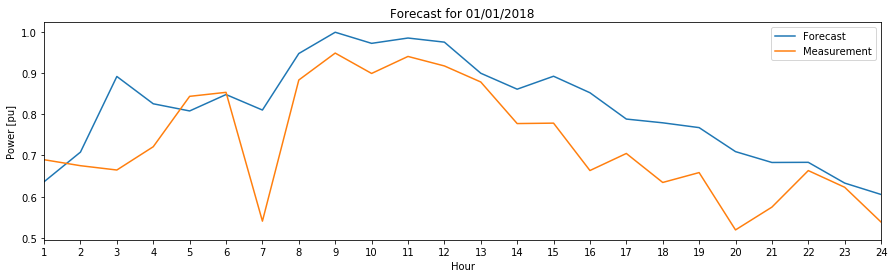

In [8]:
x = range(1,25)
y1 = predictions
y2 = result.values

plt.figure(figsize=(15,4))
plt.plot(x,y1)
plt.plot(x,y2)
ax = plt.gca()
ax.set_xlim(1,24)
ax.set_xticks(range(1,25));
ax.set_ylabel('Power [pu]')
ax.set_xlabel('Hour')
ax.set_title('Forecast for 01/01/2018')
ax.legend(['Forecast','Measurement']);
plt.savefig('1.png', bbox_inches = 'tight')

In [52]:
rmse_h = result
rmse_h['pred'] = predictions
rmse_h['hour'] = rmse_h.index.hour
rmse_h['hour'] = rmse_h['hour'].replace(0,24)
rmse_h['sq-error'] = (rmse_h['POWER'] - rmse_h['pred'])**2
rmse_h = rmse_h.groupby('hour').sum().drop(columns=['POWER','pred'])
rmse_h['RMSE'] = 100*rmse_h['sq-error']**(1/2)

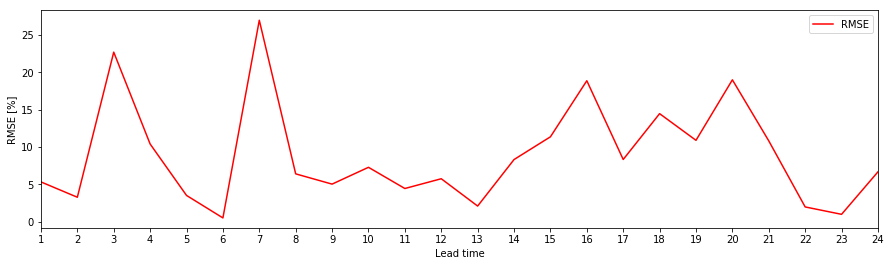

In [59]:
x = rmse_h.index
y1 = rmse_h['RMSE'].values

plt.figure(figsize=(15,4))
plt.plot(x,y1, color='red')
ax = plt.gca()
ax.set_xlim(1,24)
ax.set_xticks(range(1,25));
ax.set_ylabel('RMSE [%]')
ax.set_xlabel('Lead time')
#ax.set_title('Forecast for 01/01/2018')
ax.legend(['RMSE']);
plt.savefig('rmse_1.png', bbox_inches = 'tight')